In [ ]:
!pip install -U ferret-xai

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pre-procesamiento
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# clasificación
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin

# Modelo
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# NLP
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
import re

#nltk.download('punkt')

# Stopwords (https://github.com/xiamx/node-nltk-stopwords/blob/master/data/stopwords/spanish)
with open('spanish.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

spanish_stopwords = [line.strip() for line in lines]

# Caso
caso = 'julieta'

df = pd.read_csv(f'clean_{caso}.csv')
df_chat = pd.read_csv(f'{caso}_chat.csv')

In [ ]:
def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]

class StemmerTokenizer:
    def __init__(self):
        self.ss = SnowballStemmer('spanish')
    def __call__(self, text):
        text_tok = word_tokenize(text)
        text_tok = [t for t in text_tok if t not in spanish_stopwords]
        return [self.ss.stem(t) for t in text_tok]

df['comment'] = df['comment'].apply(remove_punctuation)

# Modelo básico

### Preprocesamiento

In [ ]:
categorical_columns = ['gender', 'sel', 'etapa']
genders = [df.gender.unique().tolist()]

categorical_preprocessing = ColumnTransformer(
    transformers=[
        ('gender', Pipeline([
            ('extract', ColumnExtractor(columns=['gender'])),
            ('onehot_encoder', OneHotEncoder(sparse=False, categories=genders))
        ]), ['gender']),
        ('sel_etapa', Pipeline([
            ('extract', ColumnExtractor(columns=['sel', 'etapa'])),
            ('ordinal_encoder', OrdinalEncoder())
        ]), ['sel', 'etapa'])
    ],
    remainder='drop'
)

categorical_pipeline = Pipeline([
    ('categorical_preprocessing', categorical_preprocessing)
])

categorical_transformed_data = categorical_pipeline.fit_transform(df)

gender_column_names = [f'gender:{category}' for category in genders[0]]
categorical_transformed_df = pd.DataFrame(categorical_transformed_data, columns=gender_column_names + ['sel', 'etapa'])
categorical_transformed_df

C:\Users\Daniel Minaya Vargas\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,gender:F,gender:M,gender:O,sel,etapa
0,1.0,0.0,0.0,5.0,1.0
1,1.0,0.0,0.0,5.0,1.0
2,1.0,0.0,0.0,2.0,1.0
3,0.0,1.0,0.0,2.0,1.0
4,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...
2206,0.0,1.0,0.0,4.0,2.0
2207,0.0,1.0,0.0,1.0,2.0
2208,0.0,1.0,0.0,4.0,2.0
2209,0.0,1.0,0.0,4.0,2.0


In [ ]:
bog = CountVectorizer(
    tokenizer= StemmerTokenizer(),
    ngram_range=(1,1)
)

text_preprocessing = ColumnTransformer(
    transformers=[
        ('bag-of-words', bog, 'comment')
    ],
    remainder='drop'
)

text_pipeline = Pipeline(
    [
        ("text_preprocessing", text_preprocessing)
    ]
)

text_transformed_data = text_pipeline.fit_transform(df).toarray()

feature_names = text_pipeline.named_steps['text_preprocessing'].named_transformers_['bag-of-words'].get_feature_names_out()
text_transformed_df = pd.DataFrame(text_transformed_data, columns=feature_names)
text_transformed_df

C:\Users\Daniel Minaya Vargas\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,1,10,100,110,12,16,2,20,23,3,...,wpp,wsp,wtsp,x,xd,yacqu,yend,zapat,ýa,ඞ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2208,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2209,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data = pd.concat([categorical_transformed_df, text_transformed_df], axis=1)
data['sel'] = data['sel'].astype('category')
data

,gender:F,gender:M,gender:O,sel,etapa,1,10,100,110,12,...,wpp,wsp,wtsp,x,xd,yacqu,yend,zapat,ýa,ඞ
0,1.0,0.0,0.0,5.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0.0,0.0,5.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.0,0.0,2.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,1.0,0.0,2.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,1.0,0.0,0.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,0.0,1.0,0.0,4.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2207,0.0,1.0,0.0,1.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2208,0.0,1.0,0.0,4.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2209,0.0,1.0,0.0,4.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_train, df_test, y_train, y_test = train_test_split(data, data['sel'], test_size=.3, stratify=data['sel'])
df_train, df_test = df_train.drop(columns=['sel']), df_test.drop(columns=['sel'])

In [ ]:
df_train

,gender:F,gender:M,gender:O,etapa,1,10,100,110,12,16,...,wpp,wsp,wtsp,x,xd,yacqu,yend,zapat,ýa,ඞ
875,0.0,1.0,0.0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
275,0.0,1.0,0.0,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
565,0.0,1.0,0.0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1893,0.0,1.0,0.0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1343,1.0,0.0,0.0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,0.0,1.0,0.0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1444,0.0,1.0,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
630,0.0,1.0,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1860,0.0,1.0,0.0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Entrenamiento

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(df_train, y_train)

print(classification_report(y_test, model.predict(df_test)))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        22
         1.0       0.33      0.12      0.18        67
         2.0       0.30      0.29      0.30       140
         3.0       0.38      0.54      0.44       182
         4.0       0.41      0.43      0.42       160
         5.0       0.43      0.33      0.38        93

    accuracy                           0.37       664
   macro avg       0.31      0.29      0.29       664
weighted avg       0.36      0.37      0.36       664



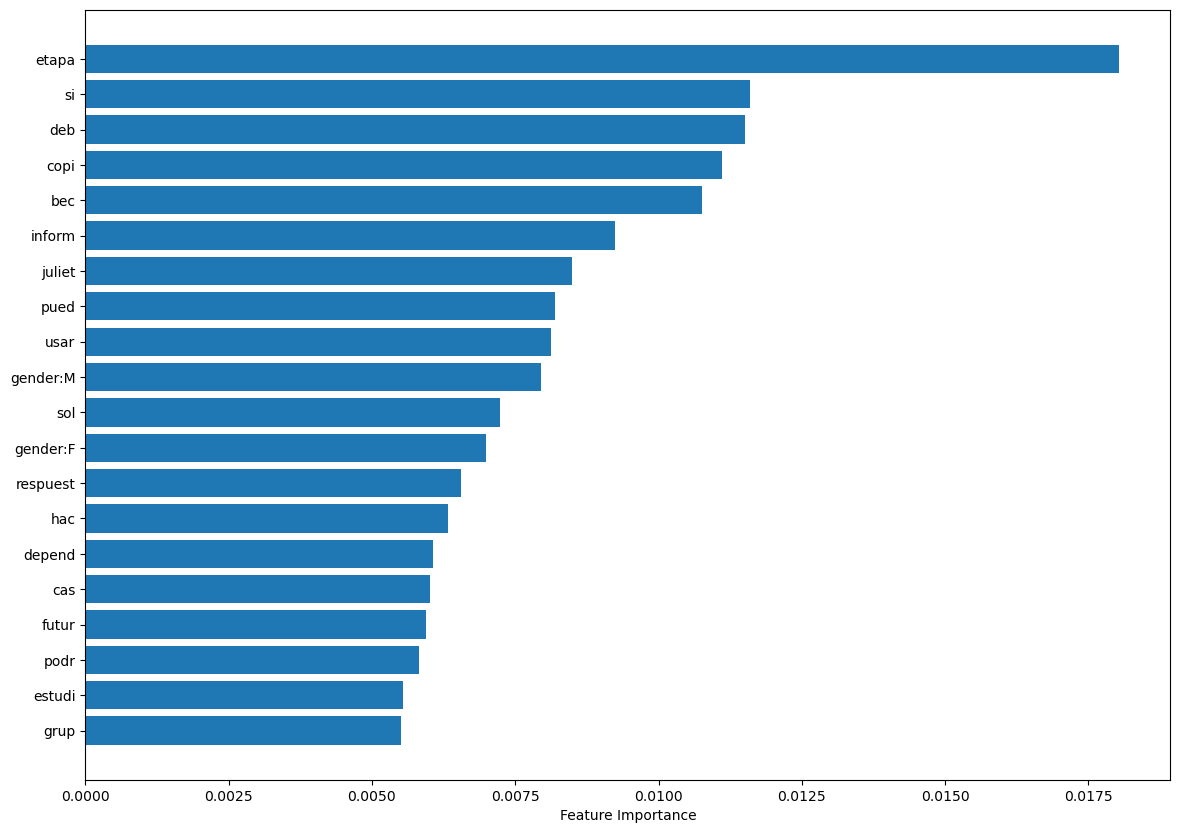

In [ ]:
feature_importances = model.feature_importances_
feature_names = df_train.columns

sorted_idx = feature_importances.argsort()[::-1]

top_50_features = [feature_names[i] for i in sorted_idx[:20]][::-1]
top_50_importances = feature_importances[sorted_idx][:20][::-1]

plt.figure(figsize=(14, 10))
plt.barh(range(len(top_50_importances)), top_50_importances)
plt.yticks(range(len(top_50_importances)), top_50_features)
plt.xlabel('Feature Importance')
plt.show()

# Modelo 1

Dada las selecciones en la etapa individual 1 y grupal, y las justificaciones en las tres etapas, predecir la selección en la etapa individual 2.

### Preprocesamiento

In [ ]:
pivoted_df = df.pivot(index='user_id', columns='etapa', values=['sel', 'comment'])
pivoted_df.columns = [f"{col[0]}_{col[1]}" for col in pivoted_df.columns]
pivoted_df.reset_index(inplace=True)
pivoted_df = pd.merge(pivoted_df, df[['user_id', 'gender']], on='user_id')
pivoted_df.drop_duplicates(inplace=True, ignore_index=True)
pivoted_df = pivoted_df[['user_id', 'gender', 'sel_Ind1', 'sel_Grup','sel_Ind2', 'comment_Ind1', 'comment_Grup','comment_Ind2']]
pivoted_df = pivoted_df.drop(columns=['user_id'])
pivoted_df

,gender,sel_Ind1,sel_Grup,sel_Ind2,comment_Ind1,comment_Grup,comment_Ind2
0,M,3,2,2,idealmente debería copiar prueba considero e...,habló grupo consideraciones económicas social...,opinión cambió aún hacia usar información con...
1,F,2,3,2,debiera usar información grupo whatsapp pues ...,mejor opción julieta usar información pues be...,sigue igual pues grupo menos misma opinión h...
2,F,3,4,4,julieta momento realizando prueba examina con...,actividad especifican si prueba define mantenc...,sabemos situación encuentra julieta capacidad...
3,M,4,5,4,dependiendo contexto julieta mencioné anterior...,personalmente insisto sigue dependiendo contex...,posición sigue igual depende contexto julieta...
4,F,6,5,5,creo pierde mas copiando través whatsapp ganan...,grupo elegimos numero 5 debería copiar exist...,luego tener conversación grupo cambiado 6 5 ...
...,...,...,...,...,...,...,...
732,M,5,5,5,debe hacerlo si bien importante mantener beca...,si bien importante mantener beca importante m...,mantener beca importante sino poder desarroll...
733,M,6,5,5,pesar suene tentador ayude cierta forma conseg...,situación extrema beca dependiera copiar seri...,general opiniones compañeros par posición ca...
734,M,6,5,5,ver todas posibles posibilidades podría genera...,pesar ideal use información whatsapp si vez v...,posición inicial ningún motivo viera respuesta...
735,F,5,5,6,debiera usar información si bien momento usar...,pensar consecuencias largo plazo situación si...,considero éticamente incorrecto usar informaci...


In [ ]:
categorical_columns = ['gender', 'sel_Ind1', 'sel_Grup','sel_Ind2']
genders = [df.gender.unique().tolist()]

categorical_preprocessing = ColumnTransformer(
    transformers=[
        ('gender', Pipeline([
            ('extract', ColumnExtractor(columns=['gender'])),
            ('onehot_encoder', OneHotEncoder(sparse=False, categories=genders))
        ]), ['gender']),
        ('sel_etapa', Pipeline([
            ('extract', ColumnExtractor(columns=['sel_Ind1', 'sel_Grup','sel_Ind2'])),
            ('ordinal_encoder', OrdinalEncoder())
        ]), ['sel_Ind1', 'sel_Grup','sel_Ind2'])
    ],
    remainder='drop'
)

categorical_pipeline = Pipeline([
    ('categorical_preprocessing', categorical_preprocessing)
])

categorical_transformed_data = categorical_pipeline.fit_transform(pivoted_df)

gender_column_names = [f'gender:{category}' for category in genders[0]]
categorical_transformed_df = pd.DataFrame(categorical_transformed_data, columns=gender_column_names + ['sel_Ind1', 'sel_Grup','sel_Ind2'])
categorical_transformed_df

C:\Users\Daniel Minaya Vargas\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,gender:F,gender:M,gender:O,sel_Ind1,sel_Grup,sel_Ind2
0,0.0,1.0,0.0,2.0,1.0,1.0
1,1.0,0.0,0.0,1.0,2.0,1.0
2,1.0,0.0,0.0,2.0,3.0,3.0
3,0.0,1.0,0.0,3.0,4.0,3.0
4,1.0,0.0,0.0,5.0,4.0,4.0
...,...,...,...,...,...,...
732,0.0,1.0,0.0,4.0,4.0,4.0
733,0.0,1.0,0.0,5.0,4.0,4.0
734,0.0,1.0,0.0,5.0,4.0,4.0
735,1.0,0.0,0.0,4.0,4.0,5.0


In [ ]:
text_columns = ['comment_Ind1', 'comment_Grup','comment_Ind2']

pivoted_df['combined_text'] = pivoted_df[text_columns].apply(lambda row: ' '.join(row), axis=1)
pivoted_df['combined_text'] = pivoted_df['combined_text'].apply(remove_punctuation)

bog = CountVectorizer(
    tokenizer= StemmerTokenizer(),
    ngram_range=(1,1)
)

text_preprocessing = ColumnTransformer(
    transformers=[
        ('bag-of-words_combined', bog, 'combined_text')
    ],
    remainder='drop'
)

text_pipeline = Pipeline(
    [
        ("text_preprocessing", text_preprocessing)
    ]
)

text_transformed_data = text_pipeline.fit_transform(pivoted_df).toarray()

feature_names_combined = text_pipeline.named_steps['text_preprocessing'].named_transformers_['bag-of-words_combined'].get_feature_names_out()
text_transformed_df = pd.DataFrame(text_transformed_data, columns=feature_names_combined)
pivoted_df.drop('combined_text', axis=1, inplace=True)
text_transformed_df

C:\Users\Daniel Minaya Vargas\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,1,10,100,110,12,16,2,20,23,3,...,wpp,wsp,wtsp,x,xd,yacqu,yend,zapat,ýa,ඞ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
733,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
734,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
735,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data = pd.concat([categorical_transformed_df, text_transformed_df], axis=1)
data[['sel_Ind1', 'sel_Grup','sel_Ind2']] = data[['sel_Ind1', 'sel_Grup','sel_Ind2']].astype('category')
data

,gender:F,gender:M,gender:O,sel_Ind1,sel_Grup,sel_Ind2,1,10,100,110,...,wpp,wsp,wtsp,x,xd,yacqu,yend,zapat,ýa,ඞ
0,0.0,1.0,0.0,2.0,1.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0.0,0.0,1.0,2.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.0,0.0,2.0,3.0,3.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,1.0,0.0,3.0,4.0,3.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,0.0,5.0,4.0,4.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,0.0,1.0,0.0,4.0,4.0,4.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
733,0.0,1.0,0.0,5.0,4.0,4.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
734,0.0,1.0,0.0,5.0,4.0,4.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
735,1.0,0.0,0.0,4.0,4.0,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_train, df_test, y_train, y_test = train_test_split(data, data['sel_Ind2'], test_size=.3, stratify=data['sel_Ind2'])
df_train, df_test = df_train.drop(columns=['sel_Ind2']), df_test.drop(columns=['sel_Ind2'])

In [ ]:
df_train

,gender:F,gender:M,gender:O,sel_Ind1,sel_Grup,1,10,100,110,12,...,wpp,wsp,wtsp,x,xd,yacqu,yend,zapat,ýa,ඞ
162,1.0,0.0,0.0,4.0,3.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
626,0.0,1.0,0.0,3.0,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
570,1.0,0.0,0.0,3.0,3.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
599,0.0,1.0,0.0,5.0,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
299,0.0,1.0,0.0,1.0,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,0.0,1.0,0.0,5.0,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127,0.0,1.0,0.0,4.0,3.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0.0,1.0,0.0,3.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
316,0.0,1.0,0.0,4.0,3.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Entrenamiento

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(df_train, y_train)

print(classification_report(y_test, model.predict(df_test)))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       1.00      0.10      0.17        21
         2.0       0.46      0.48      0.47        50
         3.0       0.46      0.62      0.53        65
         4.0       0.51      0.67      0.58        61
         5.0       0.00      0.00      0.00        18

    accuracy                           0.48       222
   macro avg       0.41      0.31      0.29       222
weighted avg       0.47      0.48      0.44       222



C:\Users\Daniel Minaya Vargas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Daniel Minaya Vargas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Daniel Minaya Vargas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


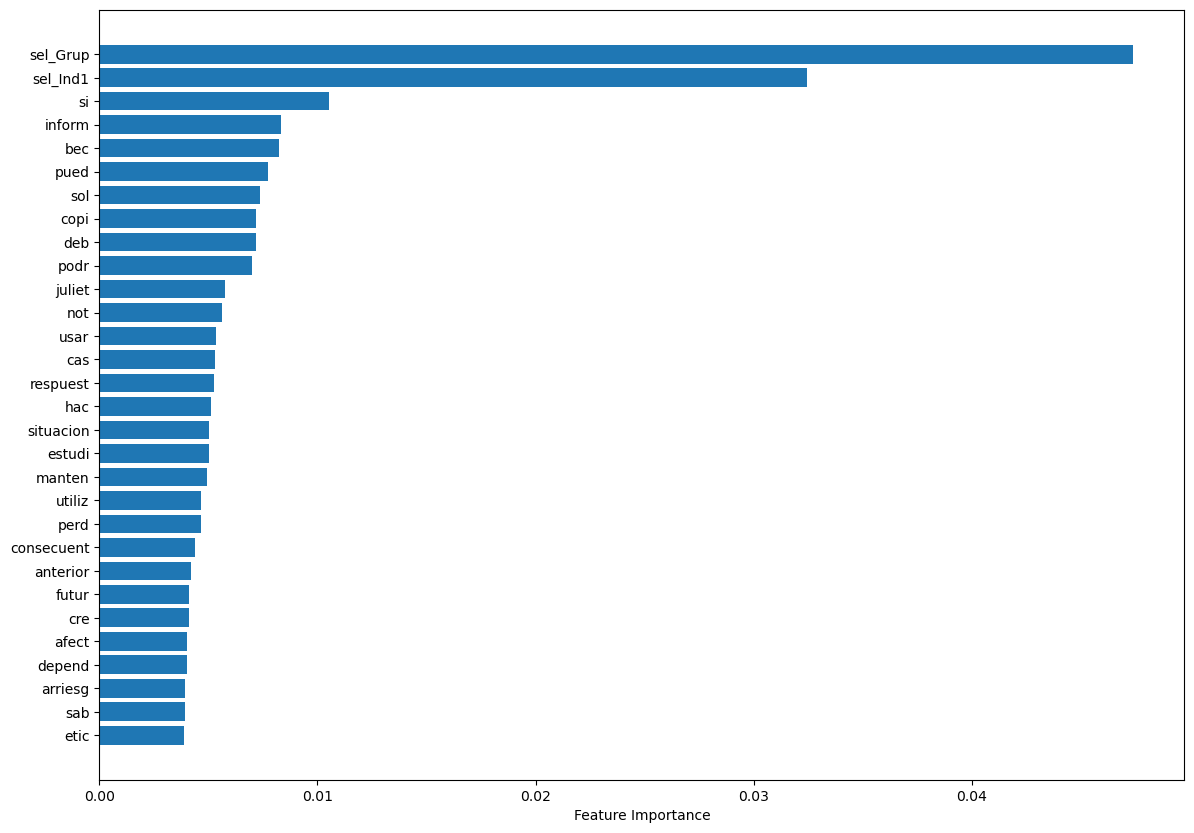

In [ ]:
feature_importances = model.feature_importances_
feature_names = df_train.columns

sorted_idx = feature_importances.argsort()[::-1]
top_number = 30

top_features = [feature_names[i] for i in sorted_idx[:top_number]][::-1]
top_importances = feature_importances[sorted_idx][:top_number][::-1]

plt.figure(figsize=(14, 10))
plt.barh(range(len(top_importances)), top_importances)
plt.yticks(range(len(top_importances)), top_features)
plt.xlabel('Feature Importance')
plt.show()

### Análisis de hiperparámetros

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
     'max_depth': [None, 10, 20, 30],
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 4]
}

model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(df_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_
best_model.fit(df_train, y_train)
y_pred = best_model.predict(df_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 0.4774774774774775


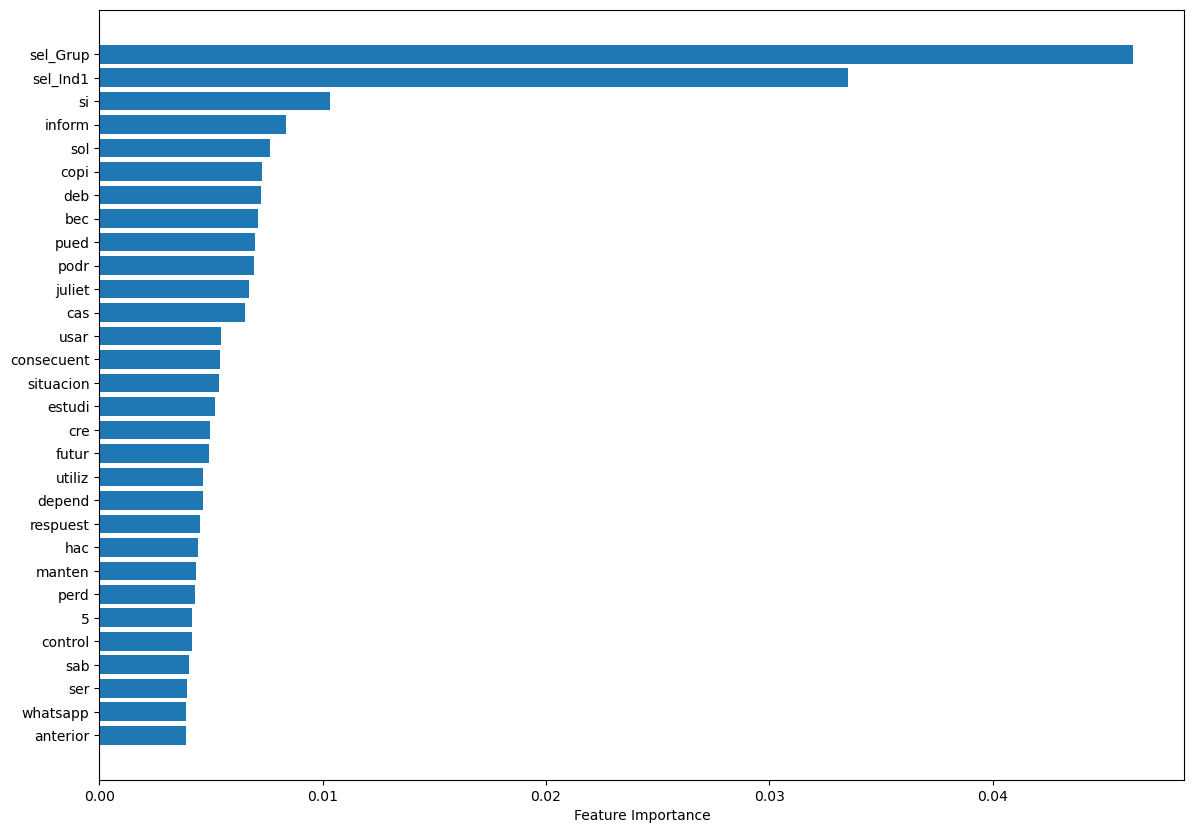

In [ ]:
feature_importances = best_model.feature_importances_
feature_names = df_train.columns

sorted_idx = feature_importances.argsort()[::-1]
top_number = 30

top_features = [feature_names[i] for i in sorted_idx[:top_number]][::-1]
top_importances = feature_importances[sorted_idx][:top_number][::-1]

plt.figure(figsize=(14, 10))
plt.barh(range(len(top_importances)), top_importances)
plt.yticks(range(len(top_importances)), top_features)
plt.xlabel('Feature Importance')
plt.show()

# Modelo Ferret

### Resumen de Chats

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Importamos el modelo de Huggings Face para resumir
model_name = "Falconsai/text_summarization"
summarization_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Definimos la función para resumir texto
def summarization(text):
    input_ids = tokenizer.encode(text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = summarization_model.generate(input_ids, max_length=150, length_penalty=2.0, num_beams=4, early_stopping=True)

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

In [ ]:
# Agrupamos por team_id
group = df_chat.groupby('team_id')
chat = []
team = []

# Exportamos cada conversación grupal en txt
for team_id, dataframe in group:
    chat_messages = [f"{row['message']}" for _, row in dataframe.iterrows()]

    team.append(team_id)
    chat.append("\n".join(chat_messages))

# Obtenemos dataframe con los chats y grupos
data = {
    'team_id': team,
    'chat': chat
}
chats = pd.DataFrame(data)

# Resumimos
chats['summary'] = chats['chat'].apply(summarization)

# Guardamos el dataframe
chats.to_csv(f'chat_resumido_{caso}.csv', index=False)

### Unión de DataFrames

In [ ]:
# Cargamos los chats resumidos
chats = pd.read_csv(f'chat_resumido_{caso}.csv')

In [ ]:
chats

,team_id,chat,summary
0,1458.0,"Hola , buenos días!\nHi uwu\nHola\nhola, buena...",":0 A, es acaso correcto recaer el acto de usar..."
1,1459.0,hola\nhola\nhola\nles parece dar su opinión ca...,yo pensando antes en cuenta que este muy mal c...
2,1460.0,A\nHola\nesto es anónimo :o\nsí :o\nya pero es...,El mo empieza con M jajajaja entonces podemos ...
3,1461.0,Hola\nHola grupo\nhola\nYo creo que debemos po...,ya respondi Julieta debe mantener su beca para...
4,1462.0,hola\nholaa\nHola\nqué opinan?\nYo creo que de...,"Yo creo que debera usar la información, ustede..."
...,...,...,...
230,1688.0,Hola\npasen el wims señores\nxdd\nEntonces...\...,Hola pasenel wims seores xdd Entonces... wims ...
231,1689.0,Holaa\nhola\nhola\npara mi debe copiar y era X...,"trabajar con ustedes Estimados, fue un gusto t..."
232,1690.0,oli\noigan\nla 3 era que podia perder la beca ...,XD La 3 era que podia perder la beca y el trab...
233,1691.0,alo\nHolaa\ny que opinan?\nbuenas buenas\nQue ...,el rato Yo digo que depende creo que si antes ...


In [ ]:
# Funcion que devuelve el team_id del user_id
def get_team_id(user_id):
    df_user_id = df[df['user_id']==user_id]
    mask = ~df_user_id['team_id'].isna()
    team_id = df_user_id[mask]['team_id'].values[0]
    return team_id

# Agregamos los team_id faltantes
df_with_team = df.copy()
df_with_team['team_id'] = df['user_id'].apply(get_team_id)

# Combinamos las justificaciones con los chats resumidos
result_df = pd.merge(df_with_team, chats, on='team_id', how='left')

# Separamos en estudiantes con chats y sin chats
users_with_chat = result_df[~result_df['chat'].isna()]
user_without_chat = result_df[result_df['chat'].isna()]

print(f'Estudiantes con chat:', len(users_with_chat) // 3)
print(f'Estudiantes sin chat:', len(user_without_chat) // 3)

Estudiantes con chat: 704
Estudiantes sin chat: 33


In [ ]:
users_with_chat

,id,user_id,team_id,gender,df,title,opt_left,opt_right,max_num,sel,comment,phase,time,curso,seccion,etapa,chat,summary
0,14218,2806,1567.0,F,1,[Ind1] Julieta en esta situación a la que se v...,Usar información del grupo de WhatsApp,No usar la información del grupo de WhatsApp,6,6,", sumario reputación .",3,2021-05-26 00:58:42.474,2021.CD1100,1,Ind1,"Holaaa\nHoli :)\nhola\nwena, ahi estamos todos...",el 4 es como el intrmedio entre los 3 Me parec...
1,14219,2889,1574.0,F,1,[Ind1] Julieta en esta situación a la que se v...,Usar información del grupo de WhatsApp,No usar la información del grupo de WhatsApp,6,6,quizá podría ayudar instante futuro afectará,3,2021-05-26 00:58:48.887,2021.CD1100,1,Ind1,esto funciona?\nhola\nhola\nholaa\nqué opinan?...,"en el grupo de wsp yes me gusta hola, hay algu..."
2,14220,2897,1556.0,F,1,[Ind1] Julieta en esta situación a la que se v...,Usar información del grupo de WhatsApp,No usar la información del grupo de WhatsApp,6,3,utilizar información whatsapp sólo si ve apuros .,3,2021-05-26 00:58:52.908,2021.CD1100,1,Ind1,copia cierto?\nhola hola\ntambien\ncopia\ncopi...,jajajajajajajajajajajajajajajajajajajajajajaja...
3,14221,2814,1563.0,M,1,[Ind1] Julieta en esta situación a la que se v...,Usar información del grupo de WhatsApp,No usar la información del grupo de WhatsApp,6,3,podria hacerlo sola comparar respuestas asegur...,3,2021-05-26 00:59:02.265,2021.CD1100,1,Ind1,buena gente\nhola\nquienes son? ndeaaaa\njajaj...,yo creo q julieta deberia solo ver el resultad...
4,14222,3334,1581.0,M,1,[Ind1] Julieta en esta situación a la que se v...,Usar información del grupo de WhatsApp,No usar la información del grupo de WhatsApp,6,1,"insisto , recursos disponibles",3,2021-05-26 00:59:05.371,2021.CD1100,1,Ind1,holi 😀\nHola\n:o\nholii\naber bamos a ber k pe...,holi Hola :o holii aber bamos a ber k pedo qu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,12852,2575,1463.0,M,1,"[Ind2] Después de la discusión en grupo, ¿cómo...",Usar información del grupo de WhatsApp,No usar la información del grupo de WhatsApp,6,3,"verdad quedo decisión neutral , dado informaci...",6,2021-05-24 18:54:43.792,2021.CD1100,9,Ind2,Hola\nhola\nhola\nque puntaje pusieron en la e...,eso no me quedo muy claro que se venga a la me...
2108,12842,2532,1483.0,M,1,"[Ind2] Después de la discusión en grupo, ¿cómo...",Usar información del grupo de WhatsApp,No usar la información del grupo de WhatsApp,6,6,"posición mantuvo , opinión grupo similar .",6,2021-05-24 18:54:54.117,2021.CD1100,9,Ind2,hola\nalguien puede leer lo que digo?\nHola\nH...,que ella no debe usar la informacion de whatsa...
2109,12849,2637,1470.0,M,1,"[Ind2] Después de la discusión en grupo, ¿cómo...",Usar información del grupo de WhatsApp,No usar la información del grupo de WhatsApp,6,3,"si , habia tomado cuenta cosas situacion educa...",6,2021-05-24 18:54:57.961,2021.CD1100,9,Ind2,"Hola\nHola\nHola\nopiniones??\nYo creo que, au...",que ella necesita la nota que necesita para la...
2110,12847,2580,1485.0,M,1,"[Ind2] Después de la discusión en grupo, ¿cómo...",Usar información del grupo de WhatsApp,No usar la información del grupo de WhatsApp,6,2,"posición cambio , gracias intercambio opinione...",6,2021-05-24 18:55:47.565,2021.CD1100,9,Ind2,Buenos días\nholaa\nempezamos?\nhay alguien má...,encuentro que es un punto algo vago como que l...


In [ ]:
pivoted_df = users_with_chat.pivot(index='user_id', columns='etapa', values=['sel', 'comment'])
pivoted_df.columns = [f"{col[0]}_{col[1]}" for col in pivoted_df.columns]
pivoted_df.reset_index(inplace=True)
pivoted_df = pd.merge(pivoted_df, users_with_chat[['user_id', 'gender', 'summary']], on='user_id')
pivoted_df.drop_duplicates(inplace=True, ignore_index=True)
pivoted_df = pivoted_df[['user_id', 'gender', 'sel_Ind1', 'sel_Grup','sel_Ind2', 'comment_Ind1', 'comment_Grup','comment_Ind2', 'summary']]
pivoted_df = pivoted_df.drop(columns=['user_id'])

# Guardamos dataframe
pivoted_df.to_csv(f'dataset_{caso}.csv', index=False)

In [ ]:
pivoted_df

,gender,sel_Ind1,sel_Grup,sel_Ind2,comment_Ind1,comment_Grup,comment_Ind2,summary
0,M,3,2,2,"idealmente , debería copiar prueba . considero...","habló grupo consideraciones económicas , socia...",opinión cambió aún hacia usar información . co...,que ella necesita la nota que necesita para la...
1,F,2,3,2,"debiera usar información grupo whatsapp , pues...","mejor opción julieta usar información , pues b...","sigue igual , pues grupo menos misma opinión ....",hola hola yo creo que s tiene que copiar yo ta...
2,F,3,4,4,"julieta momento realizando prueba , examina co...",actividad especifican si prueba define mantenc...,"sabemos situación encuentra julieta , capacida...",La verdad es que no Me entró la duda Podemos p...
3,M,4,5,4,dependiendo contexto julieta mencioné anterior...,personalmente insisto sigue dependiendo contex...,"posición sigue igual , depende contexto juliet...",en la copia s que lo debera evitar en lo posib...
4,F,6,5,5,creo pierde mas copiando través whatsapp ganan...,"grupo , elegimos numero 5 debería copiar , exi...","luego tener conversación grupo , cambiado 6 5 ...",creo que si creo que si creo que si creo que s...
...,...,...,...,...,...,...,...,...
699,M,4,4,4,depende comporten compañeros frente situacion ...,depende comporte resto,misma existen posibles casos respuesta reves,:( que vamos a poner entonce s lo de médico es...
700,F,5,5,5,mayoritariamente creo julieta debería copiar p...,"creo debería copiar , moralmente correcto opin...","grupo coincidimos opiniones , julieta recomend...","que copie solo ante extrema necesidad, pero qu..."
701,F,2,4,2,"pues puede copiar ahora mantener beca , puede ...","puede copiar mantener beca , embargo copiar fi...","pues si pierde beca puede seguir estudiando , ...","ya lo pusiste que segn yo no es copia copia, p..."
702,M,6,3,4,"juicio moral , pone riesgo peligro sabe experi...","considerando beca significa carrera , ciertas ...","si carrera dependiente beca , replantearía cop...",XD La 3 era que podia perder la beca y el trab...


### Generación de input

In [3]:
dataset = pd.read_csv(f'dataset_{caso}.csv')
dataset

,gender,sel_Ind1,sel_Grup,sel_Ind2,comment_Ind1,comment_Grup,comment_Ind2,summary
0,M,3,2,2,"idealmente , debería copiar prueba . considero...","habló grupo consideraciones económicas , socia...",opinión cambió aún hacia usar información . co...,que ella necesita la nota que necesita para la...
1,F,2,3,2,"debiera usar información grupo whatsapp , pues...","mejor opción julieta usar información , pues b...","sigue igual , pues grupo menos misma opinión ....",hola hola yo creo que s tiene que copiar yo ta...
2,F,3,4,4,"julieta momento realizando prueba , examina co...",actividad especifican si prueba define mantenc...,"sabemos situación encuentra julieta , capacida...",La verdad es que no Me entró la duda Podemos p...
3,M,4,5,4,dependiendo contexto julieta mencioné anterior...,personalmente insisto sigue dependiendo contex...,"posición sigue igual , depende contexto juliet...",en la copia s que lo debera evitar en lo posib...
4,F,6,5,5,creo pierde mas copiando través whatsapp ganan...,"grupo , elegimos numero 5 debería copiar , exi...","luego tener conversación grupo , cambiado 6 5 ...",creo que si creo que si creo que si creo que s...
...,...,...,...,...,...,...,...,...
699,M,4,4,4,depende comporten compañeros frente situacion ...,depende comporte resto,misma existen posibles casos respuesta reves,:( que vamos a poner entonce s lo de médico es...
700,F,5,5,5,mayoritariamente creo julieta debería copiar p...,"creo debería copiar , moralmente correcto opin...","grupo coincidimos opiniones , julieta recomend...","que copie solo ante extrema necesidad, pero qu..."
701,F,2,4,2,"pues puede copiar ahora mantener beca , puede ...","puede copiar mantener beca , embargo copiar fi...","pues si pierde beca puede seguir estudiando , ...","ya lo pusiste que segn yo no es copia copia, p..."
702,M,6,3,4,"juicio moral , pone riesgo peligro sabe experi...","considerando beca significa carrera , ciertas ...","si carrera dependiente beca , replantearía cop...",XD La 3 era que podia perder la beca y el trab...


In [4]:
# Función para pasar las selecciones a tokens
def replace_sel_with_tokens(value):
    return f"seleccion {value}"

# Concatenamos el input
dataset['input'] = (
    dataset['sel_Ind1'].apply(replace_sel_with_tokens) +
    '</s>' +
    dataset['sel_Grup'].apply(replace_sel_with_tokens) +
    '</s>' +
    dataset['comment_Ind1'] +
    '</s>' +
    dataset['comment_Grup'] +
    '</s>' +
    dataset['comment_Ind2'] +
    '</s>' +
    dataset['summary']
)

# Generamos los labels
dataset['labels'] = np.sign(dataset['sel_Ind2'] - dataset['sel_Ind1'])

# Pasamos al rango (0,1,2)
# 0 hubo cambio hacia abajo, es decir, sel_Ind1 > sel_Ind2
# 1 no hubo cambio
# 2 hubo cambio hacia arriba, es decir, sel_Ind1 < sel_Ind2
dataset['pytorch_labels'] = dataset['labels'] + 1

input_dataframe = dataset[['input', 'pytorch_labels']]
input_dataframe

,input,pytorch_labels
0,"seleccion 3</s>seleccion 2</s>idealmente , deb...",0
1,seleccion 2</s>seleccion 3</s>debiera usar inf...,1
2,seleccion 3</s>seleccion 4</s>julieta momento ...,2
3,seleccion 4</s>seleccion 5</s>dependiendo cont...,1
4,seleccion 6</s>seleccion 5</s>creo pierde mas ...,0
...,...,...
699,seleccion 4</s>seleccion 4</s>depende comporte...,1
700,seleccion 5</s>seleccion 5</s>mayoritariamente...,1
701,seleccion 2</s>seleccion 4</s>pues puede copia...,1
702,"seleccion 6</s>seleccion 3</s>juicio moral , p...",0


### Fine-tuning para clasificar cambio de postura

In [24]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from ferret import Benchmark
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split

# Cargamos el modelo a fine-tunear
name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(name)
tokenizer = AutoTokenizer.from_pretrained(name)

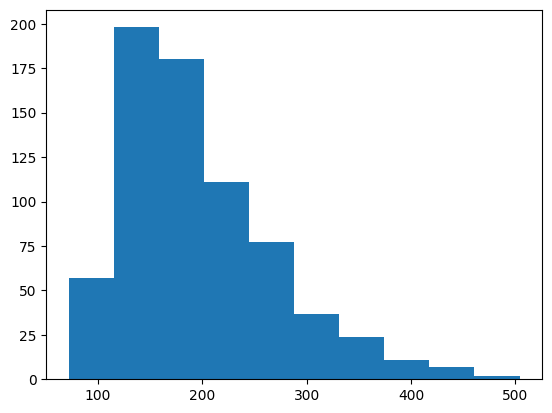

In [6]:
# Obtenemos la cantidad de tokens por input y graficamos
seq_lengths = [len(tokenizer.encode(text, padding=True, truncation=True, max_length=1024)) for text in input_dataframe['input']]
plt.hist(seq_lengths)
plt.show()

In [7]:
# Separamos feature y label
X, y = input_dataframe['input'], input_dataframe['pytorch_labels']

# Separamos en train (70%), val (20%) y test (10%)
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.33, random_state=42)

# Tokenizamos
max_length = max(seq_lengths)
X_train_tokenized = tokenizer(list(X_train), padding=True, truncation=True, return_tensors="pt", max_length=max_length)
X_val_tokenized = tokenizer(list(X_val), padding=True, truncation=True, return_tensors="pt", max_length=max_length)
X_test_tokenized = tokenizer(list(X_test), padding=True, truncation=True, return_tensors="pt", max_length=max_length)

# Pasamos a tensores
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Generamos DataSet
train_dataset = TensorDataset(X_train_tokenized['input_ids'].squeeze(), X_train_tokenized['attention_mask'].squeeze(), y_train_tensor)
val_dataset = TensorDataset(X_val_tokenized['input_ids'].squeeze(),  X_val_tokenized['attention_mask'].squeeze(), y_val_tensor)
test_dataset = TensorDataset(X_test_tokenized['input_ids'].squeeze(), X_test_tokenized['attention_mask'].squeeze(), y_test_tensor)

# Generamos DataLoader
batch_size = 1
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
from torch.optim import AdamW
from transformers import get_scheduler

# Definimos optimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

# Definimos scheduler
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Pasamos a device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

In [9]:
from tqdm import tqdm

# Entrenamos
epochs = 3
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)

    # Validamos
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation", leave=False):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_val_loss}")

Epoch 1/3, Loss: 1.0879170781290028


Epoch 2/3, Loss: 1.0918173160351499


Epoch 3/3, Loss: 1.0740473664982217


In [10]:
# Guardamos el modelo finetuneado
model.save_pretrained("fine_tuned_model")
tokenizer.save_pretrained("fine_tuned_model")

('fine_tuned_model/tokenizer_config.json',
 'fine_tuned_model/special_tokens_map.json',
 'fine_tuned_model/sentencepiece.bpe.model',
 'fine_tuned_model/added_tokens.json',
 'fine_tuned_model/tokenizer.json')

### Benchmark de Ferret

In [20]:
# Cargamos el modelo de clasificación
loaded_model = AutoModelForSequenceClassification.from_pretrained('/content/fine_tuned_model')
loaded_tokenizer = AutoTokenizer.from_pretrained('/content/fine_tuned_model')

In [15]:
# Evaluación del modelo
model.eval()

correct_predictions = 0
total_samples = 0

for batch in tqdm(test_dataloader, desc="Test", leave=False):
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    with torch.no_grad():
        outputs = loaded_model(input_ids, attention_mask=attention_mask)

    predicted_class = torch.argmax(outputs.logits, dim=-1).item()
    ground_truth = labels.item()

    correct_predictions += int(predicted_class == ground_truth)
    total_samples += 1

accuracy = correct_predictions / total_samples

print(f"Accuracy on the test dataset: {accuracy:.2%}")

Accuracy on the test dataset: 34.29%


In [28]:
# Ejemplo
bench = Benchmark(model, tokenizer)
explanations = bench.explain('You look stunning!')
bench.show_table(explanations)

Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

Token,▁You,▁look,▁stunning,!
Partition SHAP,-0.09,-0.19,-0.52,-0.19
LIME,-0.14,-0.12,-0.58,-0.16
Gradient,0.10,0.17,0.38,0.07
Gradient (x Input),0.18,0.22,0.42,0.10
Integrated Gradient,0.19,0.01,-0.41,0.25
Integrated Gradient (x Input),0.00,-0.17,-0.65,-0.17


In [30]:
evaluations = bench.evaluate_explanations(explanations, target=1)
bench.show_evaluation_table(evaluations)

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.00,1.00,0.67
LIME,0.00,1.00,0.00
Gradient,-0.25,-0.09,-1.00
Gradient (x Input),-0.25,-0.09,-1.00
Integrated Gradient,-0.11,-0.24,1.00
Integrated Gradient (x Input),-0.02,-0.34,0.33
